数据地址：https://www.kaggle.com/c/dogs-vs-cats/data


In [54]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


# 数据准备

In [55]:
import zipfile
with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as z:
    z.extractall(".")

In [56]:
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip",'r') as z:
    z.extractall(".")    

In [57]:
import os
train_path='/kaggle/working/train'
filenames=os.listdir(train_path)
# filenames

In [58]:
#猫狗分类集合
categories=[]
for f in filenames:
    category=f.split(".")[0]
    if category=='dog':
        categories.append('1')
    else:
        categories.append('0')

In [59]:
len(categories)

25000

In [60]:
import pandas as pd
train=pd.DataFrame({'file':filenames,'category':categories})
train.head()

,file,category
0,dog.5713.jpg,1
1,cat.9982.jpg,0
2,cat.5731.jpg,0
3,dog.5954.jpg,1
4,dog.4570.jpg,1


In [61]:
train['category'].value_counts()

1    12500
0    12500
Name: category, dtype: int64

# 可视化

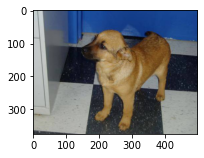

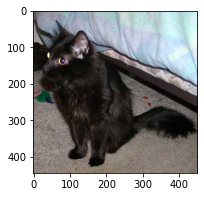

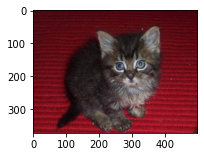

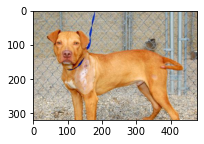

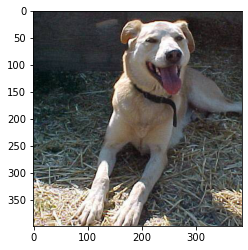

In [62]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
for i in range(5): #随机抽五张图片
    plt.figure(figsize=(10,10))
    plt.subplot(2,3,i+1)
    img_path=os.path.join(train_path,filenames[i])
    img=image.load_img(img_path)
    plt.imshow(img)
plt.tight_layout()    
plt.show()

# 准备训练模型

In [63]:
from keras.applications.vgg16 import VGG16
conv=VGG16(weights='imagenet',include_top=False,input_shape=(150,150,3))
conv.trainable=False
conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [64]:
from keras import models
from keras import layers
from keras import regularizers
model=models.Sequential()
model.add(conv)
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 18,910,017
Trainable params: 4,195,329
Non-trainable params: 14,714,688
_________________________________________________________________


In [65]:
# 定义优化器，代价函数，训练过程中计算准确率
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [66]:
train['category']=train['category'].map({'1':'dog','0':'cat'}) # '0' 是猫，’1‘是狗
from sklearn.model_selection import train_test_split
train,validate=train_test_split(train,train_size=0.8) #分割训练集和验证集

In [67]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    rescale=1./255,         # 数据归一化
    width_shift_range=0.2,  # 随机水平平移
    height_shift_range=0.2, # 随机竖直平移
    shear_range=0.5,        # 随机错切变换
    rotation_range=40,      # 随机旋转度数
    zoom_range=0.2,         # 随机放大
    horizontal_flip=True,   # 水平翻转
    fill_mode='nearest'     # 填充方式
)    

test_datagen=ImageDataGenerator(rescale=1./255) # 数据归一化

In [68]:
type(category)

str

In [69]:
# 生成训练数据
train_generator=train_datagen.flow_from_dataframe(
    train,directory=train_path,
    x_col='file',
    y_col='category',
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')
# 测试数据
test_generator=test_datagen.flow_from_dataframe(
    validate,
    directory=train_path,
    x_col='file',
    y_col='category',
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [70]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

# 数据填充

Found 1 validated image filenames belonging to 1 classes.


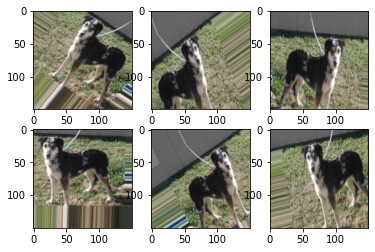

In [71]:
sample=train.sample(n=1)
sample_generator=train_datagen.flow_from_dataframe(
    sample,
    directory=train_path,
    x_col='file',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical'
)
for i in range(6):
    plt.subplot(2,3,i+1)
    for i,l in sample_generator:
        plt.imshow(i[0])
        break
plt.show()        

In [72]:
# 未优化的模型
history=model.fit(train_generator,steps_per_epoch=1000,epochs=10,validation_data=test_generator,validation_steps=250)


Epoch 1/10
1000/1000 [==============================] - 177s 177ms/step - loss: 0.8330 - accuracy: 0.7234 - val_loss: 0.3945 - val_accuracy: 0.8706
Epoch 2/10
1000/1000 [==============================] - 178s 178ms/step - loss: 0.6010 - accuracy: 0.7704 - val_loss: 0.3742 - val_accuracy: 0.8752
Epoch 3/10
1000/1000 [==============================] - 177s 177ms/step - loss: 0.5428 - accuracy: 0.7860 - val_loss: 0.3777 - val_accuracy: 0.8704
Epoch 4/10
1000/1000 [==============================] - 179s 179ms/step - loss: 0.5054 - accuracy: 0.8040 - val_loss: 0.3427 - val_accuracy: 0.8866
Epoch 5/10
1000/1000 [==============================] - 179s 179ms/step - loss: 0.4912 - accuracy: 0.8087 - val_loss: 0.3757 - val_accuracy: 0.8596
Epoch 6/10
1000/1000 [==============================] - 179s 179ms/step - loss: 0.4780 - accuracy: 0.8098 - val_loss: 0.3373 - val_accuracy: 0.8864
Epoch 7/10
1000/1000 [==============================] - 178s 178ms/step - loss: 0.4747 - accuracy: 0.8138 - val_

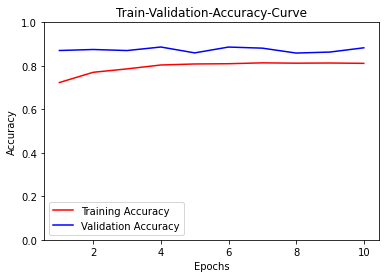

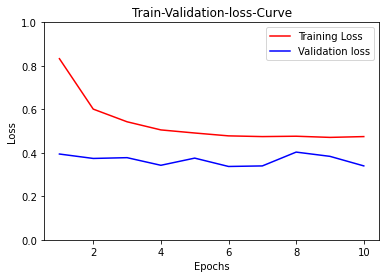

In [73]:
import matplotlib.pyplot as plt
acc=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.figure()
plt.plot(epochs,acc,'r-',label='Training Accuracy')
plt.plot(epochs,val_accuracy,'b-',label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train-Validation-Accuracy-Curve')
plt.ylim([0,1])
plt.legend()
plt.figure()
plt.plot(epochs,loss,'r-',label='Training Loss')
plt.plot(epochs,val_loss,'b-',label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train-Validation-loss-Curve')
plt.legend()
plt.ylim([0,1])
plt.show()

# 优化模型

In [74]:
train_layer=False
for i in conv.layers:
    if i.name == 'block5_conv1':
        train_layer=True
    if train_layer==True:
        i.trainable=True
        print(i,' :yes')
    else:
        print(i,' :no')

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f1e05807d90>  :no
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1e06d38fd0>  :no
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f19510615d0>  :no
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f1e06d40590>  :no
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1e06d51810>  :no
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1951058590>  :no
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f1e06d72e90>  :no
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1e06d74110>  :no
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1e06d76990>  :no
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1e06cf9a50>  :no
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f1e06cfcd50>  :no
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f1e06d00

In [75]:
from keras import optimizers
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['accuracy'])

In [76]:
# 优化后的模型
history_fine=model.fit(train_generator,steps_per_epoch=1000,epochs=10,validation_data=test_generator,validation_steps=250)

Epoch 1/10
1000/1000 [==============================] - 177s 177ms/step - loss: 0.4327 - accuracy: 0.8366 - val_loss: 0.3316 - val_accuracy: 0.8856
Epoch 2/10
1000/1000 [==============================] - 178s 178ms/step - loss: 0.4237 - accuracy: 0.8393 - val_loss: 0.3221 - val_accuracy: 0.8910
Epoch 3/10
1000/1000 [==============================] - 176s 176ms/step - loss: 0.4225 - accuracy: 0.8419 - val_loss: 0.3132 - val_accuracy: 0.8912
Epoch 4/10
1000/1000 [==============================] - 177s 177ms/step - loss: 0.4190 - accuracy: 0.8444 - val_loss: 0.3180 - val_accuracy: 0.8896
Epoch 5/10
1000/1000 [==============================] - 175s 175ms/step - loss: 0.4153 - accuracy: 0.8450 - val_loss: 0.3143 - val_accuracy: 0.8926
Epoch 6/10
1000/1000 [==============================] - 176s 176ms/step - loss: 0.4139 - accuracy: 0.8470 - val_loss: 0.3245 - val_accuracy: 0.8890
Epoch 7/10
1000/1000 [==============================] - 176s 176ms/step - loss: 0.4111 - accuracy: 0.8474 - val_

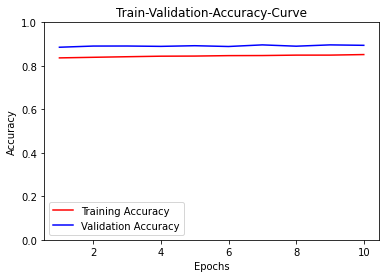

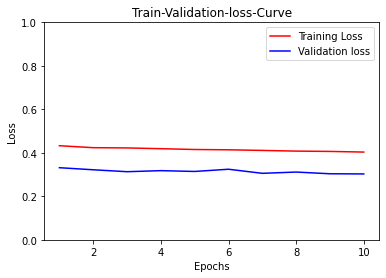

In [77]:
acc=history_fine.history['accuracy']
val_accuracy=history_fine.history['val_accuracy']
loss=history_fine.history['loss']
val_loss=history_fine.history['val_loss']
epochs=range(1,len(acc)+1)
plt.figure()
plt.plot(epochs,acc,'r-',label='Training Accuracy')
plt.plot(epochs,val_accuracy,'b-',label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train-Validation-Accuracy-Curve')
plt.ylim([0,1])
plt.legend()
plt.figure()
plt.plot(epochs,loss,'r-',label='Training Loss')
plt.plot(epochs,val_loss,'b-',label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train-Validation-loss-Curve')
plt.ylim([0,1])
plt.legend()
plt.show()

In [78]:
test_path='/kaggle/working/test1'
test_file=os.listdir('/kaggle/working/test1')

In [79]:
test_df=pd.DataFrame({'file':test_file})
test_df.head()

,file
0,10830.jpg
1,11465.jpg
2,3678.jpg
3,10788.jpg
4,7778.jpg


In [80]:
test_generator=test_datagen.flow_from_dataframe(test_df,
                                                directory=test_path,
                                                x_col='file',
                                                y_col=None,
                                                class_mode=None,
                                                target_size=(150,150),
                                                batch_size=20,
                                                shuffle=False)

Found 12500 validated image filenames.


In [81]:
predict=model.predict(test_generator,steps=625) #预测

# 预测概率

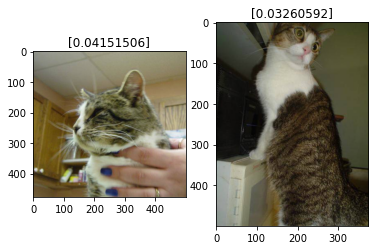

In [82]:
img=image.load_img(os.path.join(test_path,test_file[0]))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(str(predict[0]))
plt.subplot(1,2,2)
img=image.load_img(os.path.join(test_path,test_file[1]))
plt.imshow(img)
plt.title(str(predict[1]))
plt.show()

In [83]:
pred=[]
for i in predict:
    if i>0.5:
       pred.append(1)
    else:
        pred.append(0)

In [85]:
submission=test_df.copy()
submission['id']=submission['file'].str.split(".").str[0]
submission['label']=pred
submission.drop(['file'],axis=1,inplace=True)
submission['id']=submission['id'].astype('int')
submission=submission.sort_values(by=['id'])
submission.to_csv('submission.csv',index=False)

# 测试

In [4]:
 # 定义优化器，代价函数，训练过程中计算准确率
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['accuracy'])
model.fit_generator(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=20,
                    validation_data=test_generator,
                    validation_steps=len(test_generator))
model.save('model_vgg16.h5')

NameError: name 'model' is not defined

In [ ]:

from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.models import load_model
import numpy as np

label = np.array(['cat','dog'])
# 载入模型
model = load_model('model_vgg16.h5')
# 导入图片
image = load_img('/kaggle/working/test1/1003.jpg')
image

In [ ]:
image = image.resize((150,150))
image = img_to_array(image)
image = image/255
image = np.expand_dims(image,0)
image.shape

In [ ]:
print(label[model.predict_classes(image)])